# Step 1. Generate Emission Scenarios

In this demo, we create a domain of size 100 meters by 100 meters. We assign 3 potential emission sources with locations:

source_A: x, y, z = (25, 25, 2)

source_B: x, y, z = (75, 25, 2)

source_C: x, y, z = (50, 75, 3)

Each source is a group of equipment on the site. The geometric information of equipment groups is given by their vertices. 

The emission frequency for the sources are 

p_1, p_2, p_3 = (0.25, 0.25, 0.5)

The emission rate (q in [kg/h]) distribution for each source:

source_1: P(q = (1, 5, 10)) = (1/3, 1/3, 1/3)

source_2: P(q = (1, 5, 10)) = (1/3, 1/3, 1/3)

source_3: P(q = (5, 10)) = (1/2, 1/2)

We use a full year of wind data recorded from a real site. 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from windrose import WindroseAxes
import matplotlib.pyplot as plt

In [2]:
# specify dirs
data_dir = './input_data/'
save_dir = './output_data/'

In [3]:
# read in data
df_source_locs = pd.read_csv(data_dir + 'source_locations.csv')  # locations for all potential sources
df_wind = pd.read_csv(data_dir + 'wind.csv')  # a full year of wind speed and direction data on the site

## 1.1 Create emission rate distribution

In [4]:
source_names = df_source_locs['SourceName'].tolist()
source_locs = df_source_locs[['x.m', 'y.m', 'z.m']].values
#source_locs = [[25., 25., 2.], [75., 25., 2.], [50., 75., 3.]]  # potential source locations [x, y, z] in [meters]
prob_sources = [0.25, 0.25, 0.5]  # probabilities for each source
prob_rate_per_source = [[[1., 1/3], [5., 1/3], [10., 1/3]],  # [emission rate, probability] for source 1
                        [[1., 1/3], [5., 1/3], [10., 1/3]],  # [emission rate, probability] for source 2
                        [[5., 1/2], [10., 1/2]]]             # [emission rate, probability] for source 3

source_rate_dist = []  # list of tuples of (source_loc, emission rate, probability)
for i, source_loc in enumerate(source_locs):
    prob_source = prob_sources[i]
    prob_rates = prob_rate_per_source[i]
    for j, (rate, prob_rate) in enumerate(prob_rates):
        prob = prob_source * prob_rate
        result = (source_loc, rate, prob)
        source_rate_dist.append(result)

source_rate_dist

[(array([25., 25.,  2.]), 1.0, 0.08333333333333333),
 (array([25., 25.,  2.]), 5.0, 0.08333333333333333),
 (array([25., 25.,  2.]), 10.0, 0.08333333333333333),
 (array([75., 25.,  2.]), 1.0, 0.08333333333333333),
 (array([75., 25.,  2.]), 5.0, 0.08333333333333333),
 (array([75., 25.,  2.]), 10.0, 0.08333333333333333),
 (array([50., 75.,  3.]), 5.0, 0.25),
 (array([50., 75.,  3.]), 10.0, 0.25)]

## 1.2 Randomly sample wind data

In [5]:
def sample_wind_chunks(df_wind, n_samples, sample_len=60, missing_data_tol=5,
                       colname_time='TimeStamp.Mountain',
                       colname_ws='WindSpeed.m/s',
                       colname_wd='WindDirection.degree',
                       ws_valid_lb=.5, ws_valid_ub=20.,
                       seed=None):
    """
    Samples valid chunks of wind data from the given DataFrame.
    
    Parameters:
        df_wind (pd.DataFrame): DataFrame containing wind data, including timestamp, wind direction, and wind speed columns.
        n_samples (int): Desired number of valid chunks to sample.
        sample_len (int): Number of consecutive rows to include in each chunk.
        missing_data_tol (int): Maximum allowable number of NaN values in wind direction or wind speed columns for a chunk to be considered valid.
        ws_valid_lb (float, optional): Lower bound of valid wind speed value, i.e., all wind speed below this value are filtered out. Default is 0.5 m/s.
        ws_valid_ub (float, optional): Upper bound of valid wind speed value, i.e., all wind speed above this value are filtered out. Default is 20.0 m/s.
        colname_time (str): Name of the timestamp column in the DataFrame.
        colname_ws (str): Name of the wind speed column in the DataFrame.
        colname_wd (str): Name of the wind direction column in the DataFrame.
        seed (int, optional): Seed value for reproducibility of the random sampling. Default is None.
    
    Returns:
        pd.DataFrame: A concatenated DataFrame containing all sampled valid chunks of wind data.
    """
    # Set the seed for reproducibility, if provided
    if seed is not None:
        np.random.seed(seed)

    # Convert time column to datetime format
    df_wind[colname_time] = df_wind[colname_time].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z') if isinstance(x, str) else x)

    # Filter invalid wind speeds
    df_wind = df_wind[(df_wind[colname_ws] > ws_valid_lb) & (df_wind[colname_ws] < ws_valid_ub)]
    
    valid_chunks = []  # Initialize an empty list to store valid chunks
    total_rows = len(df_wind)  # Total number of rows in the DataFrame

    # Continue until the required number of valid chunks is obtained
    while len(valid_chunks) < n_samples:
        # Randomly select a starting index, ensuring enough rows remain for the full chunk
        start_index = np.random.randint(0, total_rows - sample_len)
        chunk = df_wind.iloc[start_index:start_index + sample_len].copy()  # Copy the selected chunk

        # Calculate time difference between the first and last rows of the chunk
        time_difference = chunk[colname_time].iloc[-1] - chunk[colname_time].iloc[0]

        # Validate that the time span matches the expected chunk length
        if time_difference == pd.Timedelta(minutes=sample_len - 1):
            # Count NaN values in wind direction and wind speed columns
            wd_nan_count = chunk[colname_wd].isna().sum()
            ws_nan_count = chunk[colname_ws].isna().sum()

            # Skip this chunk if NaN counts exceed the tolerance
            if wd_nan_count > missing_data_tol or ws_nan_count > missing_data_tol:
                continue

            # Fill NaN values with forward fill if within the tolerance
            if 0 < wd_nan_count <= missing_data_tol:
                chunk[colname_wd] = chunk[colname_wd].fillna(method='ffill')
            if 0 < ws_nan_count <= missing_data_tol:
                chunk[colname_ws] = chunk[colname_ws].fillna(method='ffill')

            # Reset the index and add a Chunk_Index column for easy identification
            chunk.reset_index(drop=True, inplace=True)
            chunk['ChunkIndex'] = len(valid_chunks)

            # Add the valid chunk to the list
            valid_chunks.append(chunk)

    # Concatenate all valid chunks into a single DataFrame and return it
    df_wind_samples = pd.concat(valid_chunks, ignore_index=True)

    return df_wind_samples

In [6]:
n_samples_total = 1000  # randomly select `n_samples_total` chunks
sample_len = 60  # `sample_len`-minute chunk
df_wind_samples = sample_wind_chunks(df_wind, n_samples_total, sample_len, seed=12321)

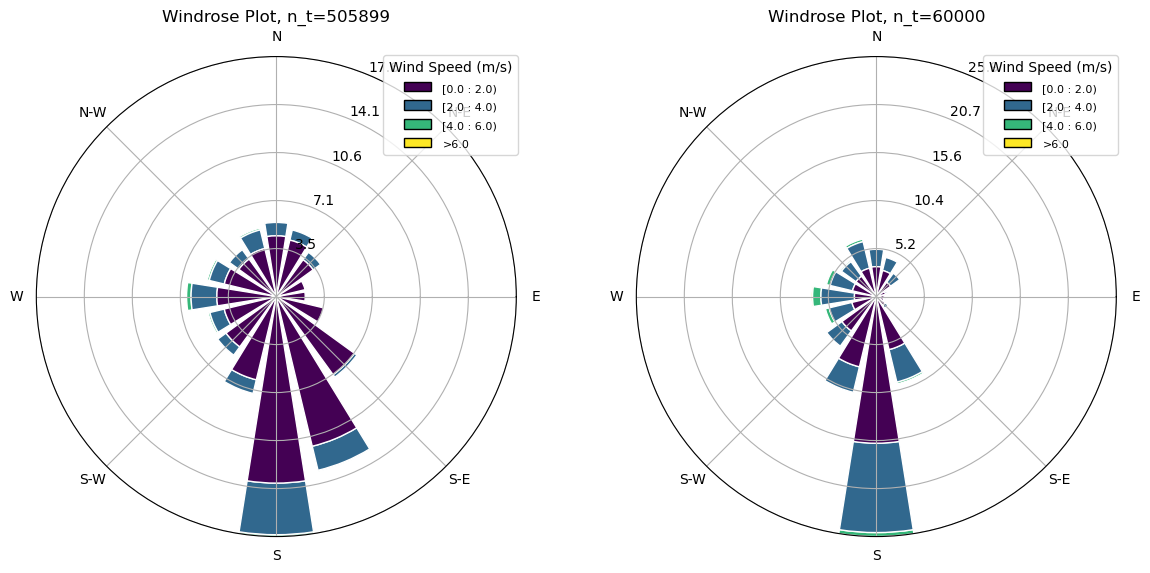

In [7]:
# check if the selected wind samples can represent the overall wind pattern
def plot_windrose(df, ax, 
                  colname_ws='WindSpeed.m/s', 
                  colname_wd='WindDirection.degree', 
                  bins=None):
    """
    Plots a windrose using the specified wind speed and wind direction columns.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing wind data.
        ws_column (str): Column name for wind speed values. Default is 'WS.ms'.
        wd_column (str): Column name for wind direction values. Default is 'WD'.
        bins (list): List of wind speed bins to use for the color bar. Default is None.
        cmap (str): Name of the color map to use. Default is 'viridis'.
    """
    # Drop rows with NaN values in the specified columns
    df = df.dropna(subset=[colname_ws, colname_wd])

    ax.bar(df[colname_wd], df[colname_ws], normed=True, opening=0.8, edgecolor='white', bins=bins, )
    
    # Set labels and legend
    ax.set_title(f'Windrose Plot, n_t={df.shape[0]}')
    ax.set_legend(title="Wind Speed (m/s)", loc='best')



fig = plt.figure(figsize=(12, 6))
ax1 = WindroseAxes.from_ax(fig=fig, rect=[0.05, 0.1, 0.4, 0.8])  # First subplot (left)
ax2 = WindroseAxes.from_ax(fig=fig, rect=[0.55, 0.1, 0.4, 0.8])  # Second subplot (right)
wind_speed_bins = [0, 2, 4, 6]
plot_windrose(df_wind, ax1, bins=wind_speed_bins)
plot_windrose(df_wind_samples, ax2, bins=wind_speed_bins)

## 1.3 Generate emission scenarios by combing emission distribution and wind chunks

In [8]:
n_samples_per_comb_list = []  # list of number of samples for each (source_loc, emission rate) combination

for i, (_, _, prob) in enumerate(source_rate_dist):
    if i < len(source_rate_dist) - 1:
        n_samples_per_comb = int(prob * n_samples_total)  # num of samples for each (source_loc, emission rate) combination 
        n_samples_per_comb_list.append(n_samples_per_comb)
    else:  # last case
        n_samples_per_comb = n_samples_total - sum(n_samples_per_comb_list) # ensure the total number of samples is n_samples
        n_samples_per_comb_list.append(n_samples_per_comb)    

In [9]:
# add source locations and emission rate columns to the sampled dataframe
df_emission_scenarios = df_wind_samples.copy()
source_xs, source_ys, source_zs, emission_rates = [], [], [], []  # Initialize an empty list to store results
for (([source_x, source_y, source_z], emission_rate, _), n) in zip(source_rate_dist, n_samples_per_comb_list):
    source_xs.extend([source_x] * sample_len * n)
    source_ys.extend([source_y] * sample_len * n)
    source_zs.extend([source_z] * sample_len * n)
    emission_rates.extend([emission_rate] * sample_len * n)

df_emission_scenarios['Source_x.m'] = source_xs
df_emission_scenarios['Source_y.m'] = source_ys
df_emission_scenarios['Source_z.m'] = source_zs
df_emission_scenarios['EmissionRate.kg/h'] = emission_rates   

df_emission_scenarios.to_csv(save_dir + 'emission_scenrios.csv', index=False)

df_emission_scenarios

,TimeStamp.Mountain,WindDirection.degree,WindSpeed.m/s,ChunkIndex,Source_x.m,Source_y.m,Source_z.m,EmissionRate.kg/h
0,2023-11-06 18:17:00-07:00,170.235,2.320004,0,25.0,25.0,2.0,1.0
1,2023-11-06 18:18:00-07:00,176.385,3.064005,0,25.0,25.0,2.0,1.0
2,2023-11-06 18:19:00-07:00,168.173,2.684004,0,25.0,25.0,2.0,1.0
3,2023-11-06 18:20:00-07:00,175.439,2.129004,0,25.0,25.0,2.0,1.0
4,2023-11-06 18:21:00-07:00,191.384,2.262004,0,25.0,25.0,2.0,1.0
...,...,...,...,...,...,...,...,...
59995,2024-03-29 09:37:00-06:00,330.479,3.433006,999,50.0,75.0,3.0,10.0
59996,2024-03-29 09:38:00-06:00,313.855,2.928005,999,50.0,75.0,3.0,10.0
59997,2024-03-29 09:39:00-06:00,273.719,2.767005,999,50.0,75.0,3.0,10.0
59998,2024-03-29 09:40:00-06:00,294.291,3.303005,999,50.0,75.0,3.0,10.0
